In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pickle
# 导入向量化后的数据集
np_vectorized_tfidf = pickle.load(open('model/vectorized_generated_corpus_tfidf.pkl', 'rb'))

In [4]:
np_vectorized_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17705395, 0.1748451 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.21242656,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [5]:
np_vectorized_tfidf.shape

(1200, 48)

In [6]:
np_vectorized_tfidf.dtype

dtype('float64')

In [7]:
# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = np_vectorized_tfidf,
                                      batch_size = 32,
                                      shuffle = True)

In [8]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # encoder
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim).double()
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim*2).double()  # 2 for mean and variance

        # decoder
        self.fc3 = torch.nn.Linear(latent_dim, hidden_dim).double()
        self.fc4 = torch.nn.Linear(hidden_dim, input_dim).double()

    def encode(self, x):
        # encoder
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # split mean and variance
        mu, log_var = x[:, :self.latent_dim], x[:, self.latent_dim:]
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # sample from a normal distribution using the mean and variance
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # decoder
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return z

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

In [27]:
# Model Initialization
input_dim = 48
hidden_dim = 32
latent_dim = 3
model = VAE(input_dim, hidden_dim, latent_dim)

# model.cuda()  # move the model to GPU

In [28]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
							lr = 0.001,
							weight_decay = 0.00000001)

In [29]:
epochs = 100
iters = 0
outputs = []
losses = []

for epoch in range(1, epochs + 1):
    print('Epoch:', epoch)
    for essay in loader:
        iters += 1

        # essay = essay.cuda()  # move data to GPU

        # forward pass
        x_reconstructed, mu, log_var = model(essay)
        reconstruction_loss = loss_function(x_reconstructed, essay)
        # kl divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # total loss
        loss = reconstruction_loss + kl_loss

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.item())
        if iters % 100 == 0:
            print(f"Iteration: {iters}, loss is: {loss.item()}")

    outputs.append((epoch, essay, x_reconstructed))

Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 100, loss is: 0.03559041082038826
Epoch: 4
Epoch: 5
Epoch: 6
Iteration: 200, loss is: 0.021627355082102052
Epoch: 7
Epoch: 8
Iteration: 300, loss is: 0.019785222987712327
Epoch: 9
Epoch: 10
Epoch: 11
Iteration: 400, loss is: 0.017946755300099242
Epoch: 12
Epoch: 13
Epoch: 14
Iteration: 500, loss is: 0.017979221923665762
Epoch: 15
Epoch: 16
Iteration: 600, loss is: 0.017951230652375885
Epoch: 17
Epoch: 18
Epoch: 19
Iteration: 700, loss is: 0.017396161771245193
Epoch: 20
Epoch: 21
Epoch: 22
Iteration: 800, loss is: 0.01692935446162419
Epoch: 23
Epoch: 24
Iteration: 900, loss is: 0.017072695015185057
Epoch: 25
Epoch: 26
Epoch: 27
Iteration: 1000, loss is: 0.017292329357108914
Epoch: 28
Epoch: 29
Iteration: 1100, loss is: 0.016591628582155023
Epoch: 30
Epoch: 31
Epoch: 32
Iteration: 1200, loss is: 0.01716125934005855
Epoch: 33
Epoch: 34
Epoch: 35
Iteration: 1300, loss is: 0.01644249582835523
Epoch: 36
Epoch: 37
Iteration: 1400, loss is: 0.0164960564111

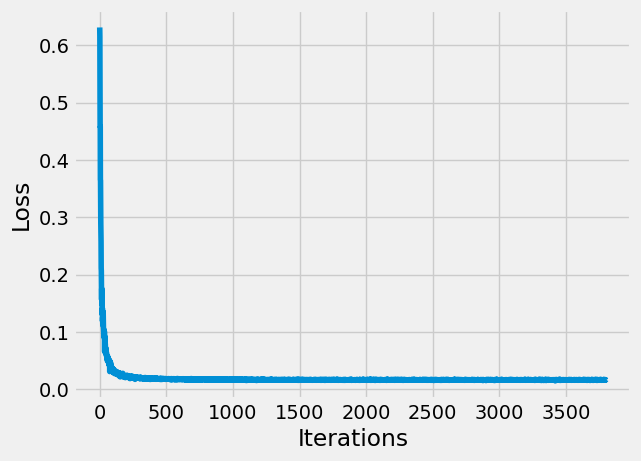

In [30]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

In [31]:
outputs[-1]

(100,
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.3904, 0.5744, 0.5886, 0.0000, 0.0000,
          0.1928, 0.0000, 0.0000, 0.1950, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.3097, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.4885, 0.2422, 0.0000, 0.2435, 0.0000, 0.0000,
          0.0000, 0.2398, 0.2374, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.5127, 0.0000, 0.0000, 0.5164, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2652, 0.2539, 0.2561,
          0.2633, 0.00

## 保存模型参数

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 保存模型参数在 Colab
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model/SixTypes-VAE-K-Means-TFIDF-3d.pth')

In [72]:
# 保存模型参数在本地
torch.save(model.state_dict(), 'model/SixTypes-VAE-K-Means-TFIDF-3d.pth')

## 加载模型参数

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 加载模型参数
model = VAE(input_dim, hidden_dim, latent_dim)
# model.cuda() # move the model to GPU

<All keys matched successfully>

In [ ]:
# Colab
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model/SixTypes-VAE-K-Means-TFIDF-3d.pth'))

In [ ]:
# 本地
model.load_state_dict(torch.load('model/SixTypes-VAE-K-Means-TFIDF-3d.pth'))

In [34]:
# Dimensionality Reduction by the trained VAE model

# decomposition_data = []
# for essay in np_vectorized_tfidf:
#     essay = torch.from_numpy(essay).cuda()
#     encoded = model.encode(essay)[0]
#     decomposition_data.append(encoded.cpu().data.numpy())
#
# decomposition_data = np.array(decomposition_data)

decomposition_data = []
for essay in np_vectorized_tfidf:
    essay = torch.from_numpy(essay.reshape(1, -1))
    # encode the data
    mu, log_var = model.encode(essay)
    # sample latent variables from the mean and variance
    encoded = model.reparameterize(mu, log_var)
    decomposition_data.append(encoded.cpu().data.numpy())

decomposition_data = np.array(decomposition_data).reshape(-1, 3)

In [35]:
decomposition_data

array([[ 1.95945196, -1.14857985,  1.21087782],
       [-0.74284683, -0.96567526,  0.21213356],
       [-0.26441024,  0.48535698, -1.0141382 ],
       ...,
       [ 1.18280755, -0.74407713, -0.26827275],
       [ 0.12986415, -0.73072188,  0.30610577],
       [ 0.2595114 , -0.3835362 ,  0.37492588]])

C:\Users\yising\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yising\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


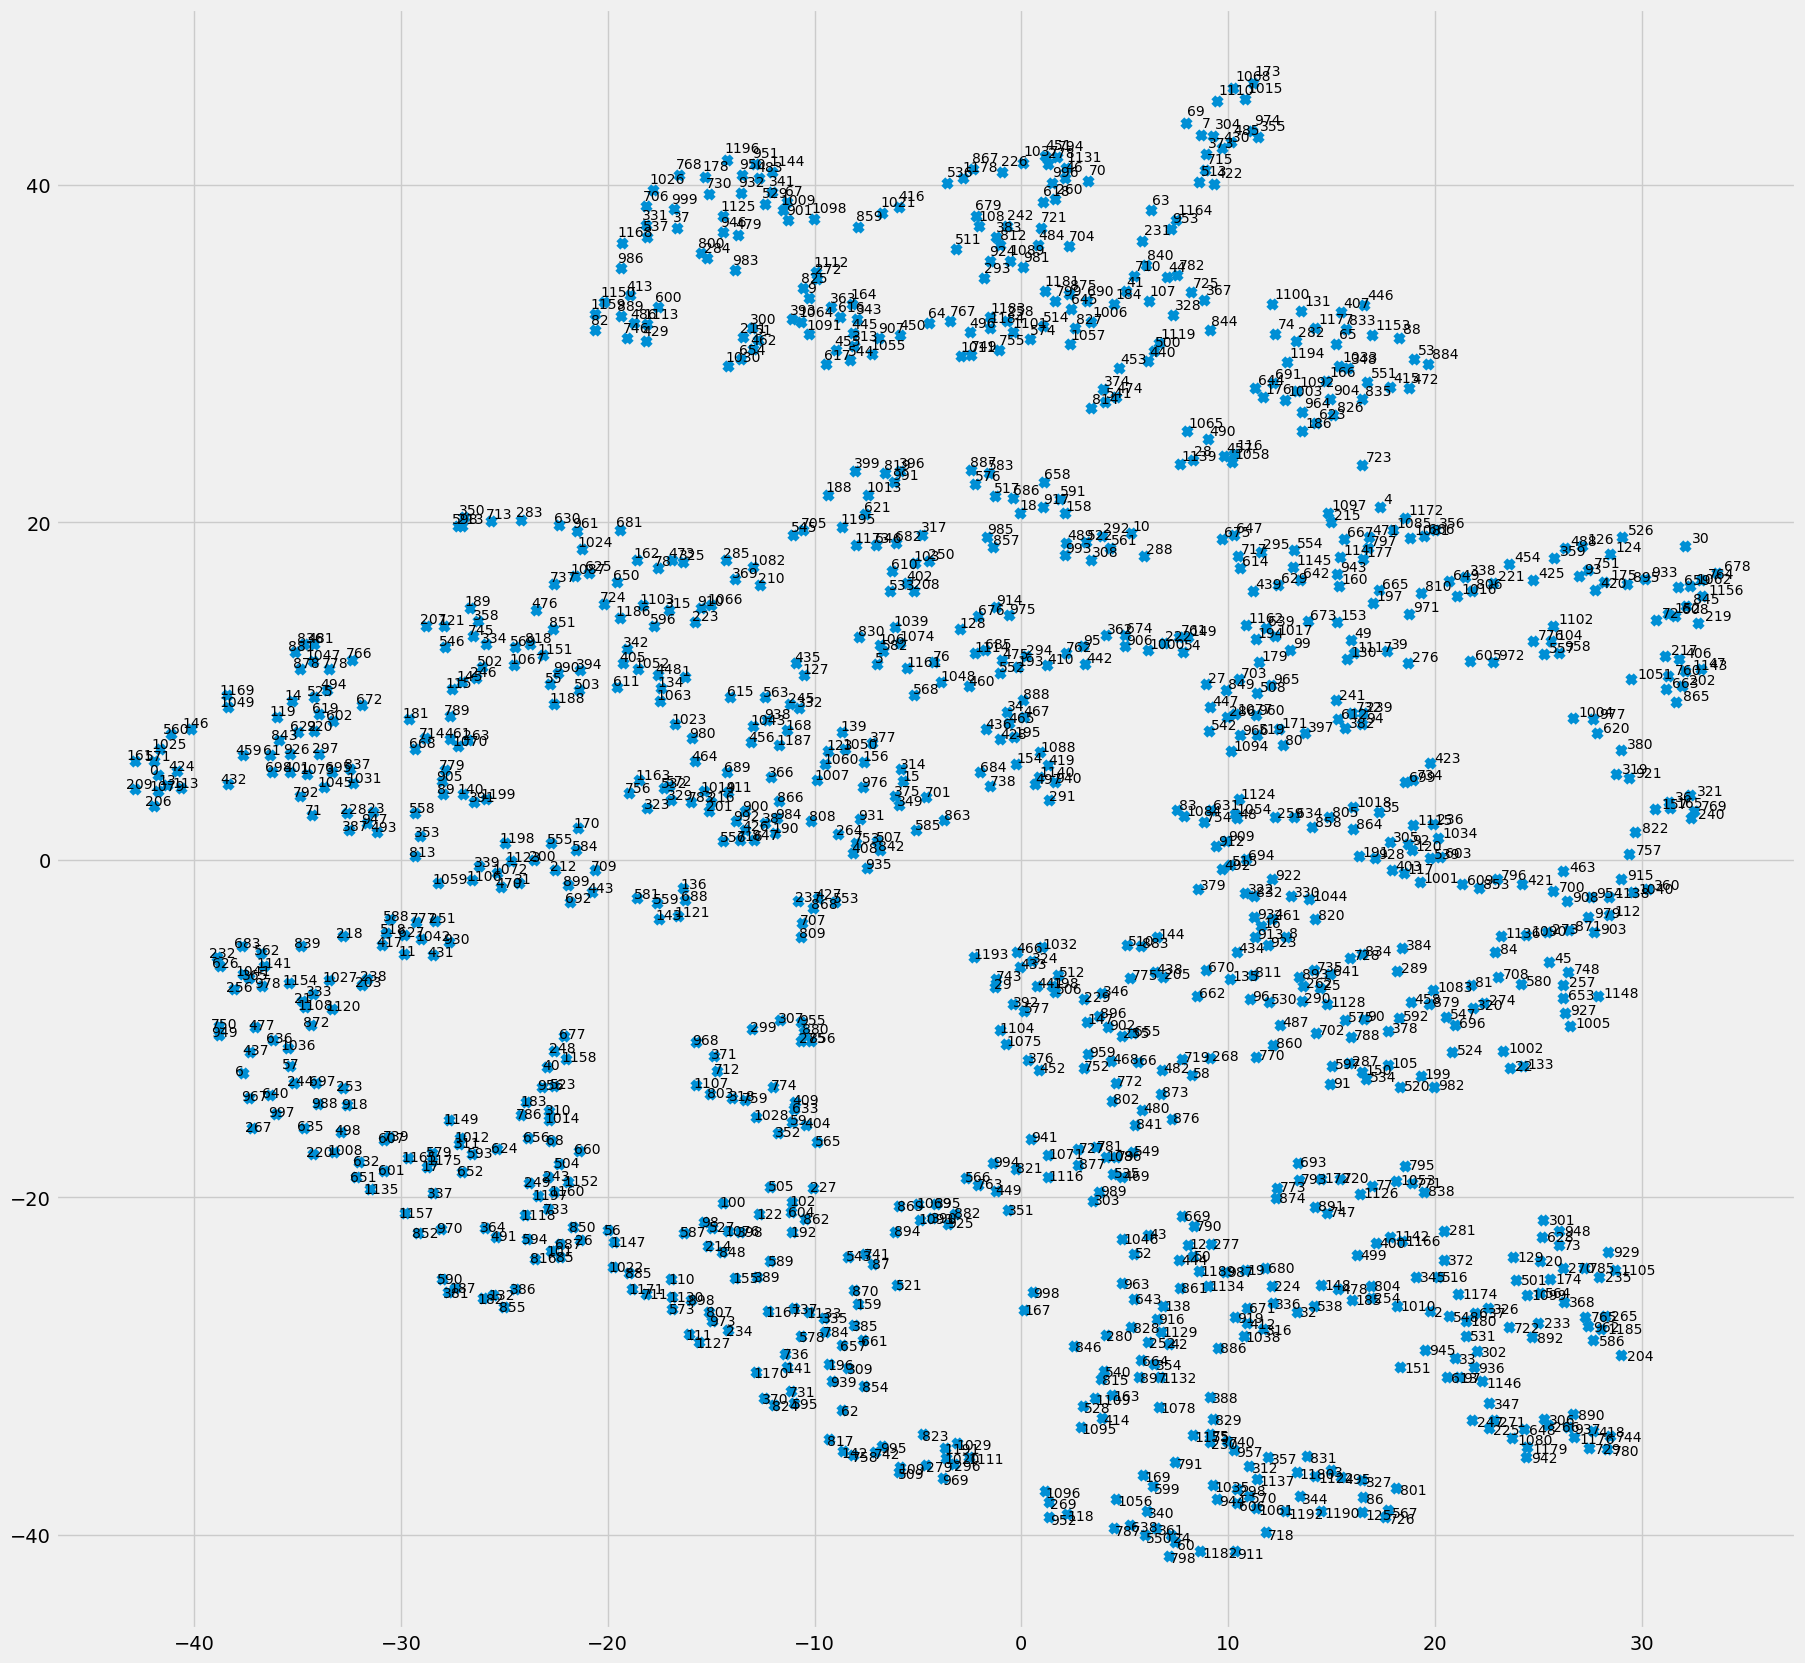

In [36]:
from sklearn.manifold import TSNE
# 画散点图之前，首先用 TSNE 降维
tsne = TSNE(n_components=2)
decomposition_data_2d = tsne.fit_transform(decomposition_data)

fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data_2d[:, 0], decomposition_data_2d[:, 1], marker='x')
for i in range(len(decomposition_data_2d)):
    plt.text(decomposition_data_2d[:, 0][i] * 1.01, decomposition_data_2d[:, 1][i] * 1.01, i, fontsize=10)
plt.show()

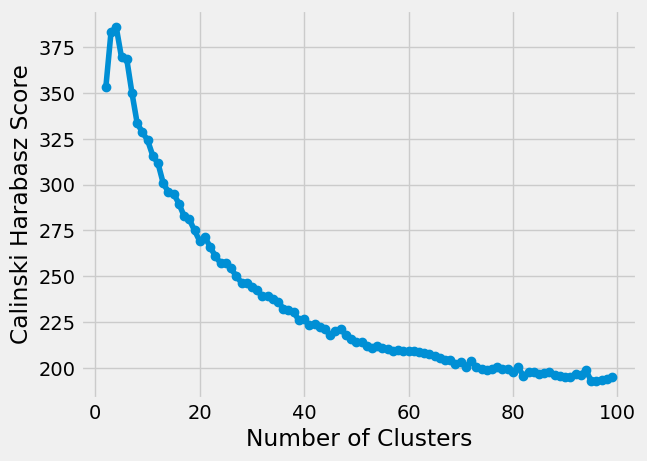

In [37]:
# K-means 算法聚类并利用 Calinski Harabasz Score 评估效果
from sklearn.cluster import KMeans
from sklearn import metrics
calinski_harabasz_score_list = []
for n_cluster in range(2, 100):
    y_pred = KMeans(n_clusters=n_cluster, init='k-means++', random_state=9).fit_predict(decomposition_data)
    current_score = metrics.calinski_harabasz_score(decomposition_data, y_pred)
    calinski_harabasz_score_list.append(current_score)

plt.plot(range(2,100), calinski_harabasz_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()

In [38]:
calinski_harabasz_score_list.index(max(calinski_harabasz_score_list))

2

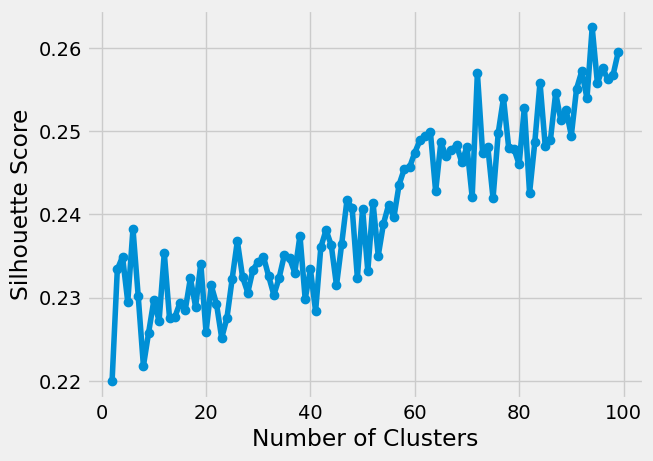

In [39]:
# K-means 算法聚类并利用 Silhouette Score（轮廓系数）评估效果
silhouette_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = metrics.silhouette_score(decomposition_data, km.labels_ , metric='euclidean')
    silhouette_score_list.append(current_score)

plt.plot(range(2,100), silhouette_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [40]:
silhouette_score_list.index(max(silhouette_score_list))

92

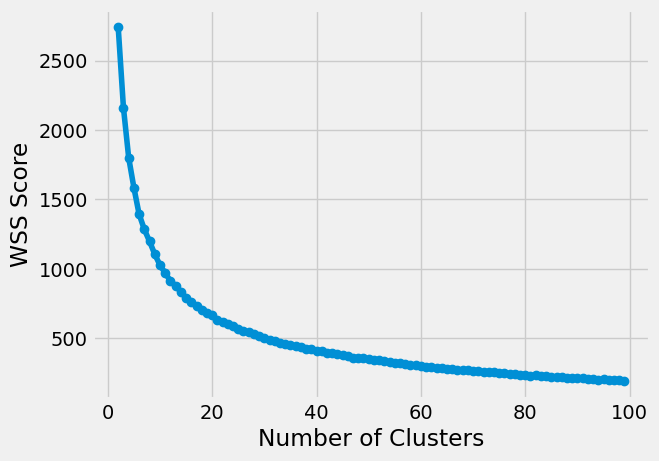

In [41]:
# K-means 算法聚类并利用 WSS（Within-cluster Sum of Squares）评估效果
WSS_score_list = []
for n_cluster in range(2, 100):
    km = KMeans(n_clusters=n_cluster, random_state=9)
    y_pred = km.fit_predict(decomposition_data)
    current_score = km.inertia_
    WSS_score_list.append(current_score)

plt.plot(range(2,100), WSS_score_list, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Score')
plt.show()

## 用 VAE 降到 3 维后直接用 K-means 来聚类

In [42]:
# 选用 k 值做 K-means 算法聚类（用 AutoEncoder 降到 3 维后直接用 K-means 聚类）
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data)

In [43]:
print(y_pred[:10])

[3 5 0 0 4 5 3 1 2 1]


In [44]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data_2d)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data_2d[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data_2d[i]))

In [45]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

3 -24.7894
5 -15.489253
0 6.7739077
4 16.56875
1 -4.464961
2 13.504947


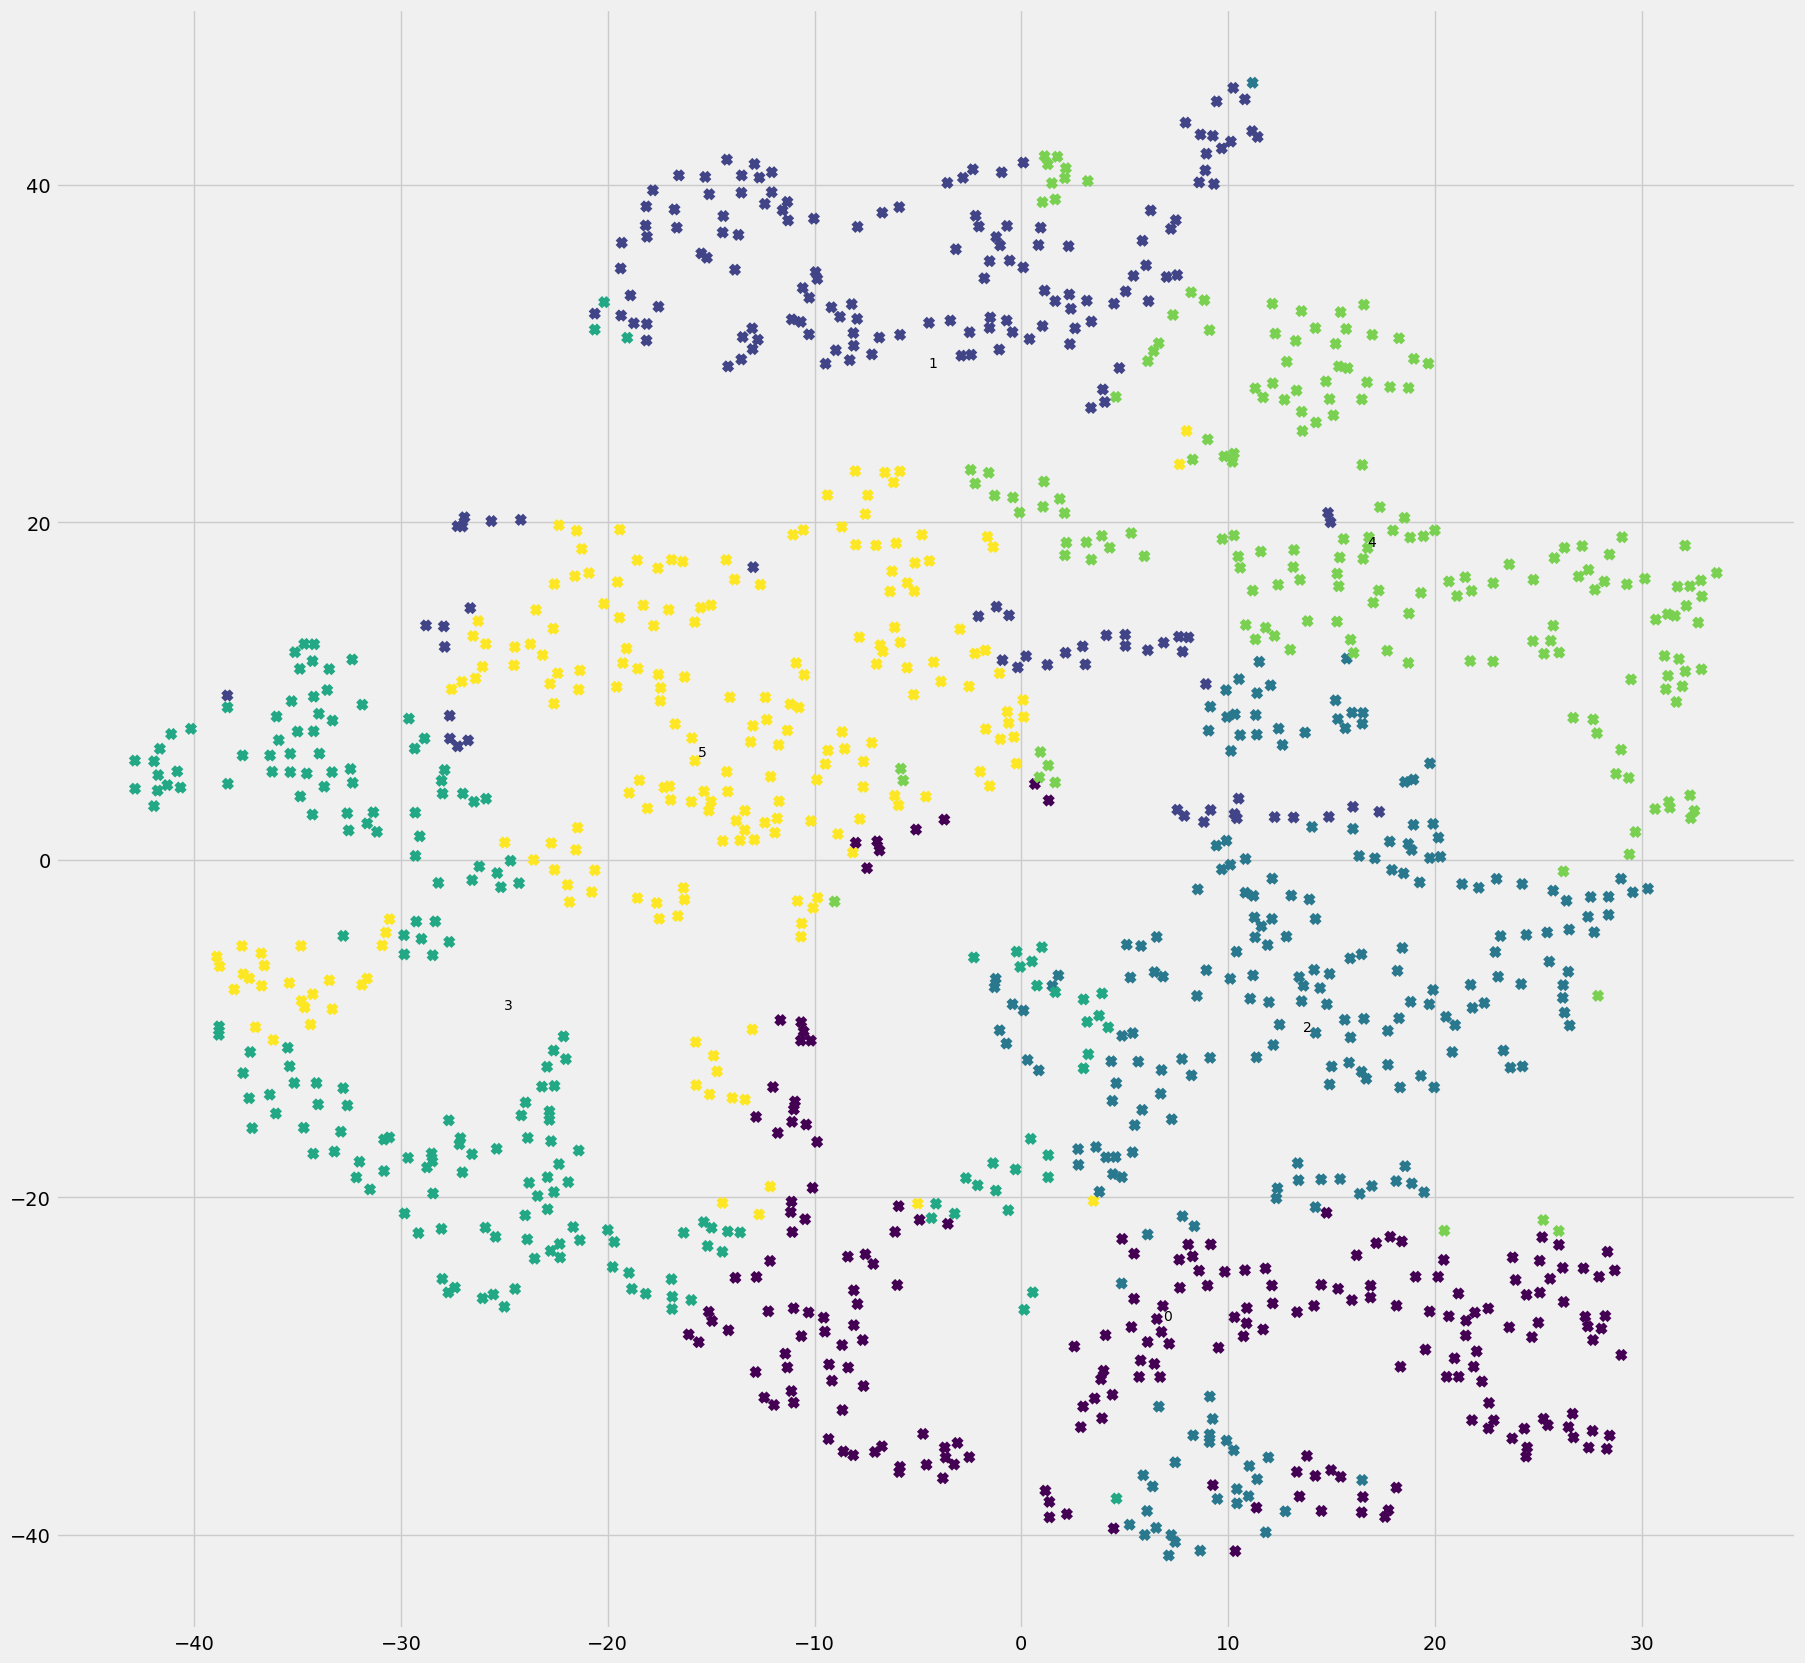

In [46]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data_2d[:, 0], decomposition_data_2d[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [47]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.calinski_harabasz_score(decomposition_data, y_pred)

368.67072704633426

In [48]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data)
metrics.silhouette_score(decomposition_data, km.labels_, metric='euclidean')

0.23826664768696473

In [49]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [50]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [51]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.homogeneity_score(labels, y_pred)

0.005602804274657081

In [52]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.completeness_score(labels, y_pred)

0.005611943479000734

In [53]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.v_measure_score(labels, y_pred)

0.005607370152935252

In [54]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_rand_score(labels, y_pred)

-0.00015226698365739848

In [55]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

-0.00025328003271318935

In [56]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.16632636828574052

## 用 VAE 降到 3 维后再用 T-SNE 降到 2 维的结果，最后用 K-means 来聚类

In [57]:
# 选用 k 值做 K-means 算法聚类（用 AutoEncoder 降到 4 维后再用 T-SNE 降到 2 维的结果，最后用 K-means 来聚类）
y_pred = KMeans(n_clusters=6, init='k-means++', random_state=9).fit_predict(decomposition_data_2d)

In [58]:
print(y_pred[:10])

[3 1 5 5 2 1 3 4 2 4]


In [59]:
import numpy as np
# 用 dict 统计出所有类别的坐标
y_pred_dict = {}
for i in range(len(decomposition_data_2d)):
    if y_pred[i] not in y_pred_dict:
        y_pred_dict[y_pred[i]] = decomposition_data_2d[i].reshape(1, 2)
    else:
        y_pred_dict[y_pred[i]] = np.vstack((y_pred_dict[y_pred[i]], decomposition_data_2d[i]))

In [60]:
for key, value in y_pred_dict.items():
    print(key, value[:, 0].mean())

3 -31.837036
1 -9.187948
5 13.439613
2 18.815378
4 -0.39779535
0 -15.34684


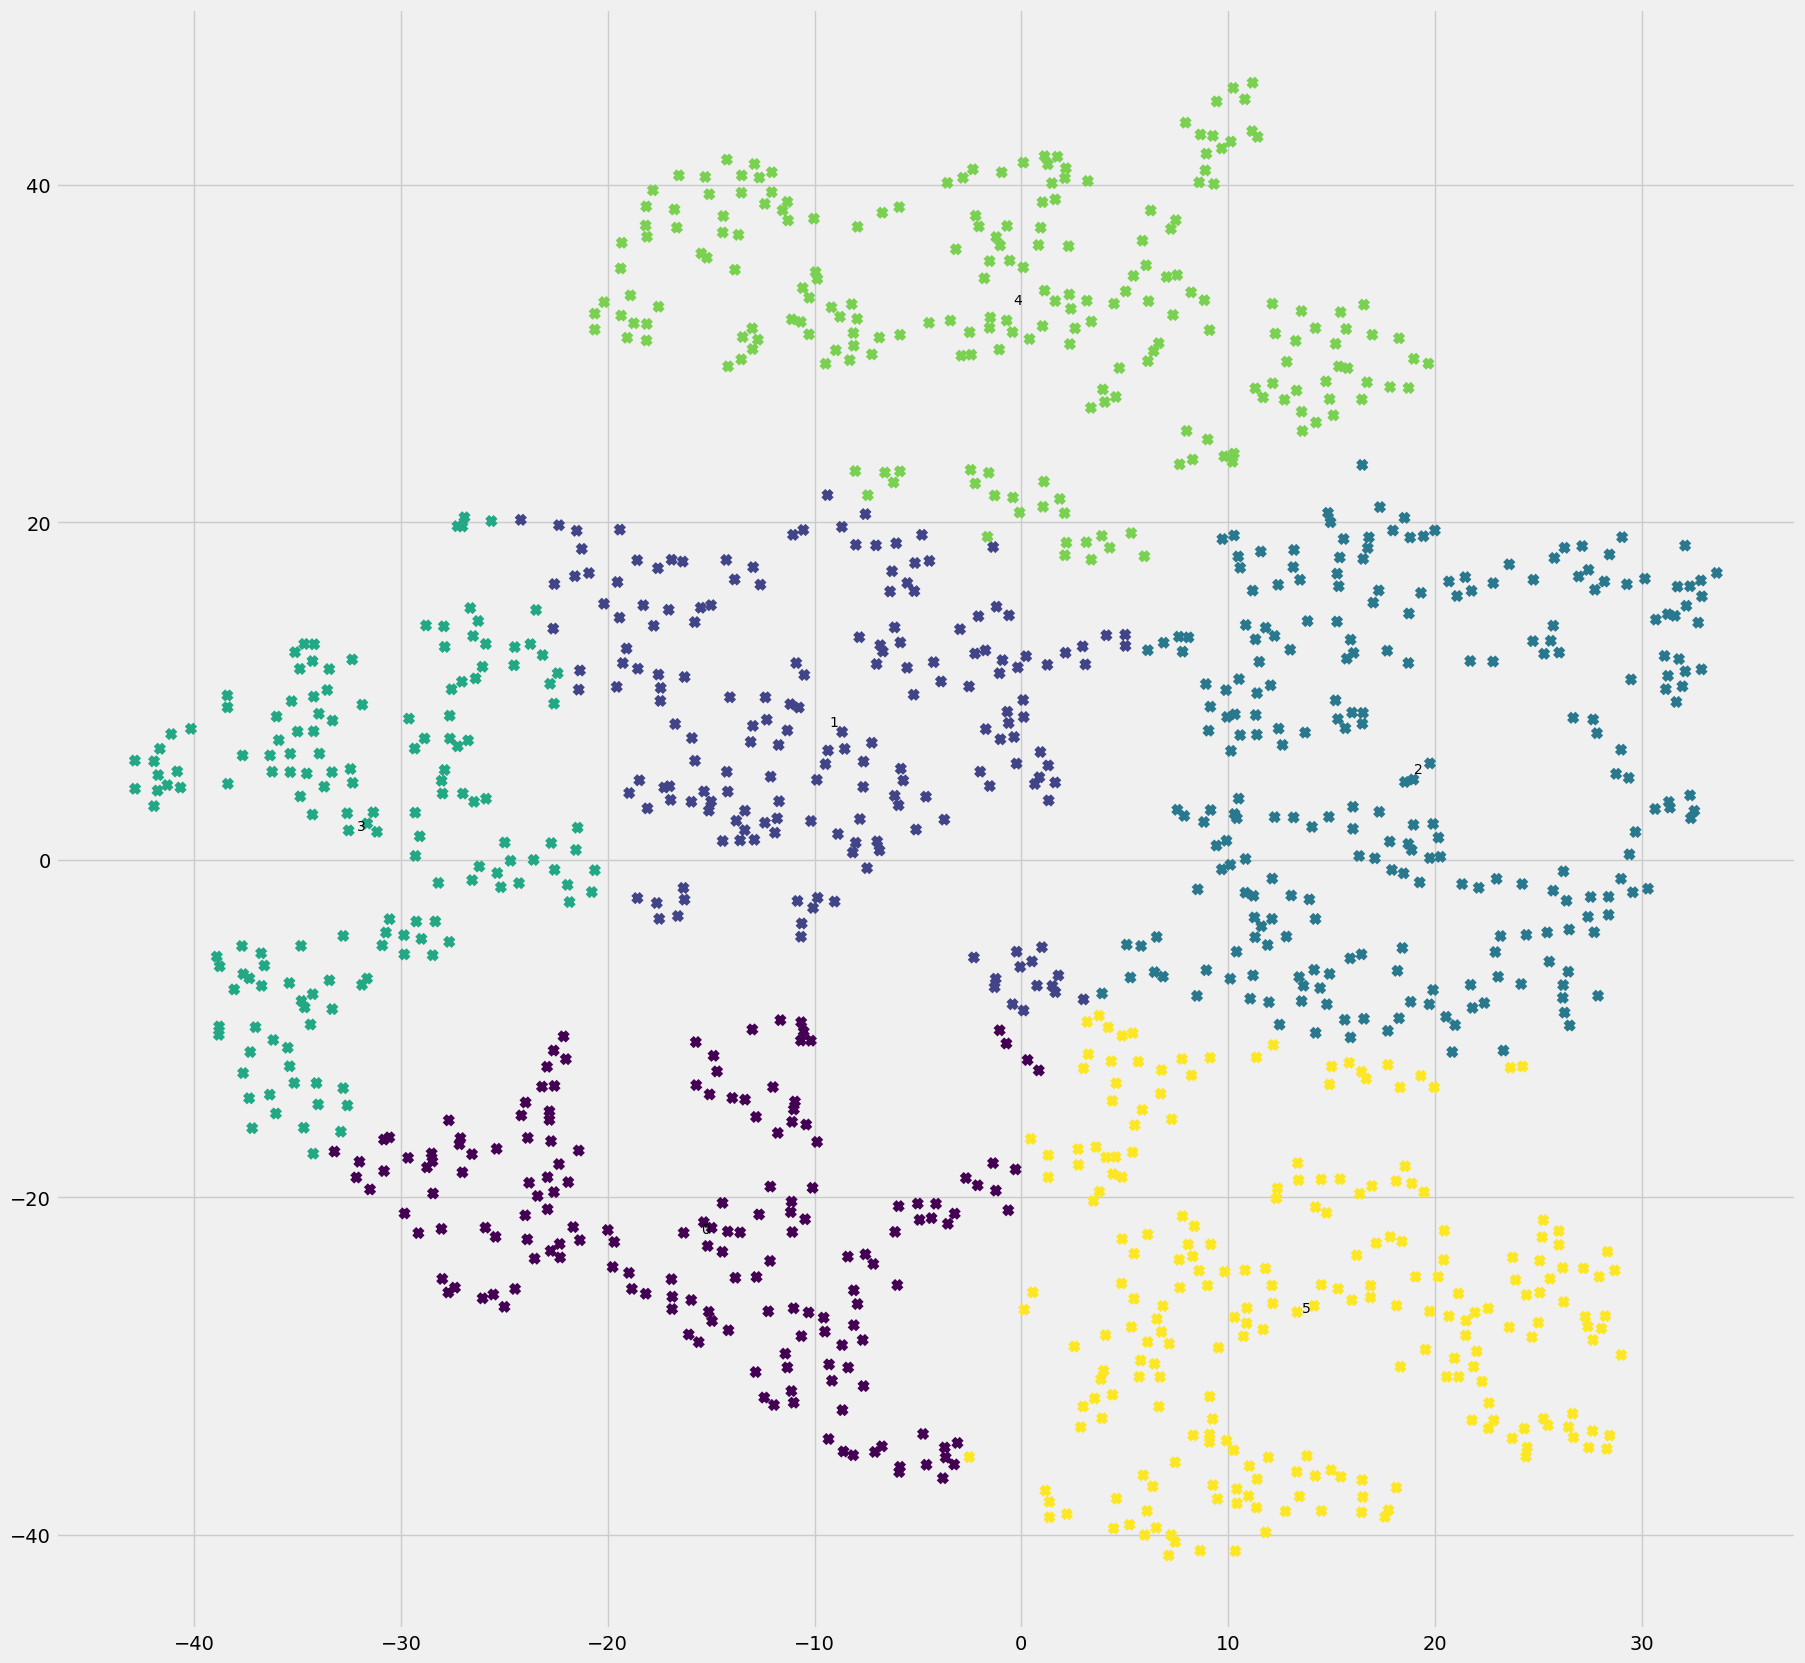

In [61]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes()
plt.scatter(decomposition_data_2d[:, 0], decomposition_data_2d[:, 1], c=y_pred, marker='x')
for key, value in y_pred_dict.items():
    plt.text(value[:, 0].mean() * 1.01, value[:, 1].mean() * 1.01, key, fontsize=10)
plt.show()

In [62]:
# 利用 Calinski Harabasz Score 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.calinski_harabasz_score(decomposition_data_2d, y_pred)

1252.0525157404693

In [63]:
# 利用 Silhouette Score（轮廓系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
km = KMeans(n_clusters=6, random_state=9)
y_pred = km.fit_predict(decomposition_data_2d)
metrics.silhouette_score(decomposition_data_2d, km.labels_, metric='euclidean')

0.40815994

In [64]:
# 读入正确标签（Labels）
labels = []
# 读入数据集
with open('sixTypes-GeneratedLabels.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        labels.append(line.strip('\n'))

In [65]:
labels[:10]

['CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP', 'CP']

In [66]:
# 利用 Homogeneity 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.homogeneity_score(labels, y_pred)

0.005833017736637095

In [67]:
# 利用 Completeness 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.completeness_score(labels, y_pred)

0.005877085166903942

In [68]:
# 利用 V-measure 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.v_measure_score(labels, y_pred)

0.005854968534548257

In [69]:
# 利用 Adjusted Rand Index（调整兰德系数）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_rand_score(labels, y_pred)

0.0003118567961347555

In [70]:
# 利用 Adjusted Mutual Information Score（调整互信息）评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.adjusted_mutual_info_score(labels, y_pred)

-2.2542623553959964e-05

In [71]:
# 利用 Fowlkes-Mallows scores 评估当前 K-Means 聚类效果（利用 TFIDF 表征）
metrics.fowlkes_mallows_score(labels, y_pred)

0.16845484805453748